<h3> Bidirectional LSTM in Keras using GloVe embeddings and nltk on TripAdvisor hotel reviews. Additional analysis done
to find the most 'positive' and 'negative' words throughout reviews. </h3>

In [1]:
import numpy as np #Lin Alg
import pandas as pd # Data preprocessing

#SkLearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

#Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
import re

#NLTK
#!pip install nltk #uncommennt this to install nltk if needed
import nltk
#nltk.download('stopwords') #uncomment these to download the stop words package if needed
from nltk.corpus import stopwords

#TextBlob
#!pip install textblob
from textblob import TextBlob

#Plotting
import matplotlib.pyplot as plt

print('Libraries imported successfully')

Using TensorFlow backend.


Libraries imported successfully


In [20]:
#Make sure the data is saved in encoding 'utf-8' format
df = pd.read_csv('hotels.csv', sep = ',')
df = df[['Review', 'Rating']]

pd.set_option('display.max_colwidth', -1)


<h3> Plot to get an idea of how many different types of reviews there are </h3>

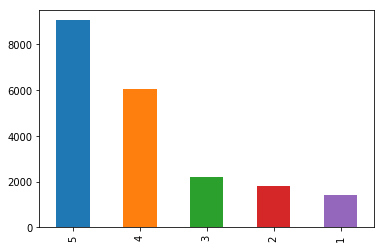

In [21]:
df['Rating'].value_counts().plot(kind = 'bar')

<h3> Clean Up reviews, this will be needed for Analysis later </h3>

In [22]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal stay hotel anniversary \tarrived late evening took advice previous reviews did valet parking \tcheck quick easy \tlittle disappointed non-existent view room room clean nice size \tbed comfortable woke stiff neck high pillows \tnot soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway \tmaybe just noisy neighbors \taveda bath products nice \tdid not goldfish stay nice touch taken advantage staying longer \tlocation great walking distance shopping \toverall nice experience having pay 40 parking night \t,4
1,ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle \tstart booked suite paid extra website description not \tsuite bedroom bathroom standard hotel room \ttook printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast \tgot kidding \tembassy suits sitting room bathroom bedroom unlike kimpton calls suite \t5 day stay offer correct false advertising \tsend kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution \tsend email trip guest survey did not follow email mail \tguess tell concerned guest.the staff ranged indifferent not helpful \tasked desk good breakfast spots neighborhood hood told no hotels \tgee best breakfast spots seattle 1/2 block away convenient hotel does not know exist \tarrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good \tgot nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate \ttold needed foam pillows \tarrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property \timpressed left morning shopping room got short trips 2 hours \tbeds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night \tlight sensitive tape controls.this not 4 start hotel clean business hotel super high rates \tbetter chain hotels seattle \t,2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized \tmissed 3 separate wakeup calls \tconcierge busy hard touch \tdid n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled \tcomparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay \tnight got 12/1a checked voucher bottle champagne nice gesture fish waiting room \timpression room huge open space felt room big \ttv far away bed chore change channel \tipod dock broken disappointing.in morning way asked desk check thermostat said 65f 74 2 degrees warm try cover face night bright blue light kept \tgot room night no \t1st drop desk \tcalled maintainence came look thermostat told play settings happy digital box wo n't work \tasked wakeup 10am morning did n't happen \tcalled later 6pm nap wakeup forgot \t10am wakeup morning yep forgotten.the bathroom facilities great room surprised room sold whirlpool bath tub n't bath amenities \tgreat relax water jets going \t,3
3,unique \tgreat stay \twonderful time hotel monaco \tlocation excellent short stroll main downtown shopping area \tpet friendly room showed no signs animal hair smells \tmonaco suite sleeping area big striped curtain

<h3> Decipher what a 'positive' and 'negative' review is and replace Rating column values in df </h3>

In [23]:
positive_reviews = df.loc[df['Rating'] >= int(3), 'Rating']
negative_reviews = df.loc[df['Rating'] <= int(2), 'Rating']

df.Rating.replace(positive_reviews, 'Positive', inplace=True, regex= True)
df.Rating.replace(negative_reviews, 'Negative', inplace=True, regex = True)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal stay hotel anniversary \tarrived late evening took advice previous reviews did valet parking \tcheck quick easy \tlittle disappointed non-existent view room room clean nice size \tbed comfortable woke stiff neck high pillows \tnot soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway \tmaybe just noisy neighbors \taveda bath products nice \tdid not goldfish stay nice touch taken advantage staying longer \tlocation great walking distance shopping \toverall nice experience having pay 40 parking night \t,Positive
1,ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle \tstart booked suite paid extra website description not \tsuite bedroom bathroom standard hotel room \ttook printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast \tgot kidding \tembassy suits sitting room bathroom bedroom unlike kimpton calls suite \t5 day stay offer correct false advertising \tsend kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution \tsend email trip guest survey did not follow email mail \tguess tell concerned guest.the staff ranged indifferent not helpful \tasked desk good breakfast spots neighborhood hood told no hotels \tgee best breakfast spots seattle 1/2 block away convenient hotel does not know exist \tarrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good \tgot nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate \ttold needed foam pillows \tarrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property \timpressed left morning shopping room got short trips 2 hours \tbeds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night \tlight sensitive tape controls.this not 4 start hotel clean business hotel super high rates \tbetter chain hotels seattle \t,Negative
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized \tmissed 3 separate wakeup calls \tconcierge busy hard touch \tdid n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled \tcomparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay \tnight got 12/1a checked voucher bottle champagne nice gesture fish waiting room \timpression room huge open space felt room big \ttv far away bed chore change channel \tipod dock broken disappointing.in morning way asked desk check thermostat said 65f 74 2 degrees warm try cover face night bright blue light kept \tgot room night no \t1st drop desk \tcalled maintainence came look thermostat told play settings happy digital box wo n't work \tasked wakeup 10am morning did n't happen \tcalled later 6pm nap wakeup forgot \t10am wakeup morning yep forgotten.the bathroom facilities great room surprised room sold whirlpool bath tub n't bath amenities \tgreat relax water jets going \t,Positive
3,unique \tgreat stay \twonderful time hotel monaco \tlocation excellent short stroll main downtown shopping area \tpet friendly room showed no signs animal hair smells \tmonaco suite sleeping are

In [24]:
#Confirm all values were changed to either negative or positive in the Ratings column
df.Rating.isnull().sum()

0

<h3> Nice all reviews have been changed, Let's clean these reviews they look pretty sloppy </h3>

In [25]:
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '\t' ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

def clean_sen(x):
    x = str(x)

    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)
    
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
    
    for pun in strip_chars:
        x = x.replace(pun, ' ')
        
    for pun in puncts:
        x = x.replace(pun, f' {pun} ')
        
    x = x.replace(" '", ' ')
    x = x.replace("' ", ' ')
    
    return x

df['Review'] = df['Review'].apply(clean_sen)

#Stop words used from NLTK library are commonly used in English language but have no predictive power in practice
stop_ = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_))

In [26]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillows soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe noisy neighbors aveda bath products nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay 40 parking night,Positive
1,ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle start booked suite paid extra website description suite bedroom bathroom standard hotel room took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast got kidding embassy suits sitting room bathroom bedroom unlike kimpton calls suite 5 day stay offer correct false advertising send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution send email trip guest survey follow email mail guess tell concerned guest staff ranged indifferent helpful asked desk good breakfast spots neighborhood hood told hotels gee best breakfast spots seattle 1 / 2 block away convenient hotel know exist arrived late night 11 pm inside run bellman busy chating cell phone help bags prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate told needed foam pillows arrival champagne strawberries foam pillows great room view alley high rise building good better housekeeping staff cleaner room property impressed left morning shopping room got short trips 2 hours beds comfortable good ac heat control 4 x 4 inch screen bring green shine directly eyes night light sensitive tape controls 4 start hotel clean business hotel super high rates better chain hotels seattle,Negative
2,nice rooms 4 * experience hotel monaco seattle good hotel n 4 * level positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized missed 3 separate wakeup calls concierge busy hard touch n provide guidance special requests tv hard use ipod sound dock suite non functioning decided book mediterranean suite 3 night weekend stay 1st choice rest party filled comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower stay hotel arrange car service price 53 tip reasonable driver waiting arrival checkin easy downside room picked 2 person jacuzi tub bath accessories salts bubble bath n stay night got 12 / 1a checked voucher bottle champagne nice gesture fish waiting room impression room huge open space felt room big tv far away bed chore change channel ipod dock broken disappointing morning way asked desk check thermostat said 65f 74 2 degrees warm try cover face night bright blue light kept got room night 1st drop desk called maintainence came look thermostat told play settings happy digital box wo n work asked wakeup 10am morning n happen called later 6pm nap wakeup forgot 10am wakeup morning yep forgotten bathroom facilities great room surprised room sold whirlpool bath tub n bath amenities great relax water jets going,Positive
3,unique great stay wonderful time hotel monaco location excellent short stroll main downtown shopping area pet friendly room showed signs animal hair smells monaco suite sleeping area big striped curtains pulled closed nice touch felt cosy goldfish named brandi enjoyed n partake free wine coffee / tea service lobby thought great feature great staff friendly free wireless internet hotel worked suite 2 laptops decor lovely e

In [27]:
df_1 = df[df['Rating'] == 'Positive'].sample(frac=1)
df_2 = df[df['Rating'] == 'Negative'].sample(frac=1)

sample_sizes = min(len(df_1), len(df_2))

data = pd.concat([df_1.head(sample_sizes), df_2.head(sample_sizes)]).sample(frac=1)

In [28]:
data['d'] = df['Review'].apply(lambda x: len(str(x).split(' ')))
print('mean length of review: ' + str(data.d.mean()))
print('max length of review: ' + str(data.d.max()))
print('std dev length of review: ' + str(data.d.std()))

mean length of review: 109.36947728686994
max length of review: 1926
std dev length of review: 103.62077144270127


<h3> Solid review sizes, and a lot of variation between them </h3>

<h3> Time to use Tokenizer </h3>

In [29]:
max_features =  51643 # number of words we care about 

sequence_length = 1926 #max review length from above

tokenizer = Tokenizer(num_words=max_features, split= ' ', oov_token = '<unk>', filters = ' ')
tokenizer.fit_on_texts(data['Review'].values)

#Take sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(data['Review'].values)

#pad the sequences so they area all same len
X = pad_sequences(X, sequence_length)

y = pd.get_dummies(data['Rating']).values # binary

#See if this works
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)


print('test set size = ' + str(len(X_test)))
print(y)

test set size = 643
[[1 0]
 [0 1]
 [1 0]
 ...
 [0 1]
 [1 0]
 [1 0]]


<h1> GloVe Embeddings </h1>

In [30]:
embeddings_index = {}

fi = open('glove.6B.100d.txt')
for line in fi:
    values = line.split()
    word = values[0]
    coeffs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coeffs
fi.close()

print('# of word vectors: {}'.format(len(embeddings_index)))

# of word vectors: 400000


<h3> Unique tokens </h3>

In [31]:
word_index = tokenizer.word_index
print('# of unique tokens: {}'.format(len(word_index)))

# of unique tokens: 30165


<h3> Find the word embedding (or vector) for each </h3>

In [32]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 100

#Create matrix of zeros, used as our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

#for each word in the tokenizer lets try to find that work in our word 2 vec model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        #word exists, add its vector to th matrix
        embedding_matrix[i] = embedding_vector
    else:
        #word does not exist, assign random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

30166


<h3> The model. Need to specify the embeddings matrix (vectors that are representing the words) using Bi-Directional LSTM </h3>

In [33]:
model = Sequential()

model.add(Embedding(num_words, embedding_dim, embeddings_initializer = Constant(embedding_matrix), input_length = sequence_length, 
                   trainable = True))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Bidirectional(LSTM(32)))
#Dropout some 'neurons'
model.add(Dropout(0.5))
#Use softmax activation function, cross entropy loss as loss function, and adam for our optimizer
model.add(Dense(units = 2, activation= 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1926, 100)         3016600   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1926, 100)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1926, 128)         84480     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 3,142,426
Trainable params: 3,142,426
Non-trainable params: 0
_________________________________________________________________


In [34]:
batch_size = 128

#8 epochs gives best results after running for 10 epochs this was discovered b/cuz validation acc dips after 8 epochs
reviews_ = model.fit(X_train, y_train, epochs = 8, batch_size = batch_size, verbose = 1, validation_split = 0.1)

Train on 5206 samples, validate on 579 samples
Epoch 1/8
5206/5206 [==============================] - 338s 65ms/step - loss: 0.6577 - acc: 0.6020 - val_loss: 0.4985 - val_acc: 0.7668
Epoch 2/8
5206/5206 [==============================] - 331s 64ms/step - loss: 0.5180 - acc: 0.7612 - val_loss: 0.3848 - val_acc: 0.8428
Epoch 3/8
5206/5206 [==============================] - 340s 65ms/step - loss: 0.4822 - acc: 0.7735 - val_loss: 0.3982 - val_acc: 0.8480
Epoch 4/8
5206/5206 [==============================] - 334s 64ms/step - loss: 0.3926 - acc: 0.8406 - val_loss: 0.3781 - val_acc: 0.8463
Epoch 5/8
5206/5206 [==============================] - 335s 64ms/step - loss: 0.3476 - acc: 0.8598 - val_loss: 0.4483 - val_acc: 0.8152
Epoch 6/8
5206/5206 [==============================] - 397s 76ms/step - loss: 0.3253 - acc: 0.8730 - val_loss: 0.2993 - val_acc: 0.8722
Epoch 7/8
5206/5206 [==============================] - 336s 64ms/step - loss: 0.2516 - acc: 0.9065 - val_loss: 0.2655 - val_acc: 0.9033
E

<h3> Plot the training and validation accuracy and loss </h3>

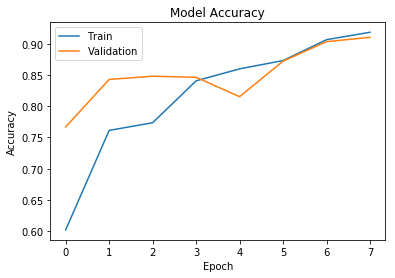

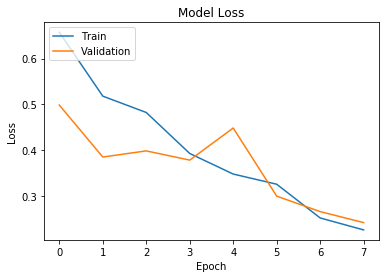

In [35]:
#Accuracy Plot
plt.plot(reviews_.history['acc'])
plt.plot(reviews_.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')

plt.show()

#Loss Plot
plt.plot(reviews_.history['loss'])
plt.plot(reviews_.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')

plt.show()

<h3> Predict yhat using model </h3>

In [36]:
yhat = model.predict(X_test)

In [37]:
accu_ = accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), yhat)))
print(accu_)

0.8989113530326595


<h3> About 90% accuracy using bi-directional LSTM model, nice! </h3>

In [38]:
#Confusion Matrix
con = confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), yhat)))
con

array([[286,  36],
       [ 29, 292]])

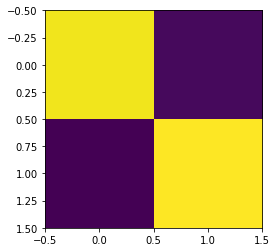

In [39]:
plt.imshow(con)

In [58]:
df_result = pd.DataFrame(list(zip(df['Review'].values, list(map(lambda x: np.argmax(x), yhat)))), columns = ['Review', 'Rating'])

df_result.head()

,Review,Rating
0,nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillows soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe noisy neighbors aveda bath products nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay 40 parking night,1
1,ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle start booked suite paid extra website description suite bedroom bathroom standard hotel room took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast got kidding embassy suits sitting room bathroom bedroom unlike kimpton calls suite 5 day stay offer correct false advertising send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution send email trip guest survey follow email mail guess tell concerned guest staff ranged indifferent helpful asked desk good breakfast spots neighborhood hood told hotels gee best breakfast spots seattle 1 / 2 block away convenient hotel know exist arrived late night 11 pm inside run bellman busy chating cell phone help bags prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate told needed foam pillows arrival champagne strawberries foam pillows great room view alley high rise building good better housekeeping staff cleaner room property impressed left morning shopping room got short trips 2 hours beds comfortable good ac heat control 4 x 4 inch screen bring green shine directly eyes night light sensitive tape controls 4 start hotel clean business hotel super high rates better chain hotels seattle,1
2,nice rooms 4 * experience hotel monaco seattle good hotel n 4 * level positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized missed 3 separate wakeup calls concierge busy hard touch n provide guidance special requests tv hard use ipod sound dock suite non functioning decided book mediterranean suite 3 night weekend stay 1st choice rest party filled comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower stay hotel arrange car service price 53 tip reasonable driver waiting arrival checkin easy downside room picked 2 person jacuzi tub bath accessories salts bubble bath n stay night got 12 / 1a checked voucher bottle champagne nice gesture fish waiting room impression room huge open space felt room big tv far away bed chore change channel ipod dock broken disappointing morning way asked desk check thermostat said 65f 74 2 degrees warm try cover face night bright blue light kept got room night 1st drop desk called maintainence came look thermostat told play settings happy digital box wo n work asked wakeup 10am morning n happen called later 6pm nap wakeup forgot 10am wakeup morning yep forgotten bathroom facilities great room surprised room sold whirlpool bath tub n bath amenities great relax water jets going,1
3,unique great stay wonderful time hotel monaco location excellent short stroll main downtown shopping area pet friendly room showed signs animal hair smells monaco suite sleeping area big striped curtains pulled closed nice touch felt cosy goldfish named brandi enjoyed n partake free wine coffee / tea service lobby thought great feature great staff friendly free wireless internet hotel worked suite 2 laptops decor lovely eclectic mix pattens c

<h1> We can begin our postive 'words' and negative 'words' analysis </h1>

In [59]:
def get_senti(x):
    return TextBlob(x).sentiment

df['Sentiment'] = df['Review'].apply(get_senti)

df.Sentiment.head()

0    (0.20874404761904758, 0.687)              
1    (0.23338827838827841, 0.49013634513634513)
2    (0.2673160173160173, 0.6080808080808081)  
3    (0.5048245614035087, 0.6912280701754385)  
4    (0.47115384615384615, 0.6293956043956045) 
Name: Sentiment, dtype: object

In [125]:
X = df['Review']
y = df['Rating']
print(X.shape)
print(y.shape)

(20491,)
(20491,)


In [126]:
transform = CountVectorizer().fit(X)

print(len(transform.vocabulary_))

51643


In [127]:
X = transform.transform(X)

X.shape

(20491, 51643)

<h3> Now need to split on the new X and y after Count Vectorizer fitting </h3>

In [128]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size = 0.1, random_state = 101)
X_train_2.shape

(18441, 51643)

<h3> We will test using Logistic Regression since it is relatively easy to understand and implement </h3>

In [152]:
from sklearn.linear_model import LogisticRegression

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c, solver = 'lbfgs', max_iter = 10000)
    lr.fit(X_train_2, y_train_2)
    print('Accuracy for C = {} : {}'.format(c, accuracy_score(y_test_2, lr.predict(X_test_2))))

Accuracy for C = 0.01 : 0.9302439024390244
Accuracy for C = 0.05 : 0.9370731707317074
Accuracy for C = 0.25 : 0.9321951219512196
Accuracy for C = 0.5 : 0.9307317073170732
Accuracy for C = 1 : 0.9307317073170732


In [153]:
final_lr_model = LogisticRegression(C= 0.05, solver = 'lbfgs', max_iter = 10000)
final_lr_model.fit(X_train_2, y_train_2)
print('Overall Accuracy : {}'.format(accuracy_score(y_test_2, lr.predict(X_test_2))))

Overall Accuracy : 0.9307317073170732


<h3> Now we get top 10 positive words and top 10 negative words corresponding to that respective category of reviews 
using Logistic Regression with C= 0.05 because it performed better</h3>

<h1> Words Mostly Associated to a Positive Review </h1>

In [157]:
feature_coef = {word : coef for word, coef in zip(transform.get_feature_names(), final_lr_model.coef_[0])}

for best_positive in sorted(feature_coef.items(), key = lambda x: x[1], reverse=True)[:10]: 
    print(best_positive)

('loved', 0.8140508523841947)
('perfect', 0.7949666034866935)
('wonderful', 0.7102937613085645)
('fantastic', 0.6699652884654091)
('excellent', 0.6389494482345646)
('great', 0.6068718683343799)
('fabulous', 0.541926637198534)
('spacious', 0.52058053850218)
('comfortable', 0.5000367412602873)
('enjoyed', 0.4946711496072644)


<h1> Words Mostly Associated to a Negative Review </h1>

In [158]:
for best_negative in sorted(feature_coef.items(), key = lambda x: x[1])[:10]: 
    print(best_negative)

('worst', -0.8383362053385586)
('terrible', -0.8228379404261366)
('dirty', -0.7464824525802413)
('rude', -0.7239107302506289)
('unhelpful', -0.5785387292649637)
('disappointing', -0.5713684387394983)
('poor', -0.5554382901106442)
('horrible', -0.5446870922647401)
('awful', -0.5139837815091789)
('disappointed', -0.48009535595221675)


<h3> Thank you for looking at my project </h3>